# 引入必要的库

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from typing import *
from enum import Enum
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# 属性类型，对应无关属性、标称属性、数值属性

In [2]:
class AttributeType(Enum):
    Nonsense = 0
    Nominal = 1
    Numeric = 2

# 缺失值处理方法

In [3]:
class MissingProcessing(object):
    # 将缺失部分剔除
    @staticmethod
    def eliminate(data_array: np.ndarray) -> list:
        return [data for data in data_array if not np.isnan(data)]

    # 用最高频率值来填补缺失值
    @staticmethod
    def frequencyFill(data_array: np.ndarray) -> np.ndarray:
        if len(data_array.shape) == 1:
            data_array = data_array.reshape(-1, 1)
        return SimpleImputer(strategy='most_frequent').fit_transform(data_array).reshape(-1)

    # 通过属性的相关关系来填补缺失值，这里使用贝叶斯回归算法
    @staticmethod
    def relevanceFill(data_array: np.ndarray) -> np.ndarray:
        if len(data_array.shape) == 1:
            data_array = data_array.reshape(-1, 1)
        return IterativeImputer().fit_transform(data_array).reshape(-1)

    # 通过数据对象之间的相似性来填补缺失值，这里使用knn算法
    @staticmethod
    def similarityFill(data_array: np.ndarray) -> np.ndarray:
        if len(data_array.shape) == 1:
            data_array = data_array.astype(float).reshape(-1, 1)
        return KNNImputer().fit_transform(data_array).reshape(-1)

    def __init__(self,
                 method: Callable[[np.ndarray], Union[list, np.ndarray]]):
        self.method = method

    def __call__(self, data_array: np.ndarray) -> Union[list, np.ndarray]:
        return self.method(data_array)

# 数据摘要

In [4]:
def dataSummary(data_frame: DataFrame,
                attribute_types: List[AttributeType],
                missing_method: Callable[[np.ndarray], Union[list, np.ndarray]]) -> List:
    # 统计数据取值的频数
    def getFrequency(data_array: np.ndarray) -> dict:
        frequency_dict = {}
        for data in data_array:
            try:
                frequency_dict[data] += 1
            except KeyError:
                frequency_dict[data] = 1
        return frequency_dict

    # 获得数据的5数概括、nan值个数以及处理nan值后的数据
    def statistics(data_array: np.ndarray) -> Tuple[float, float, float, float, float, int, list]:
        nan_sum = sum(1 for data in data_array if np.isnan(data))
        if nan_sum > 0:
            data_array = missing_method(data_array)
        describe = pd.Series(list(data_array)).describe()
        return describe['min'], describe['25%'], describe['50%'], describe['75%'], describe['max'],  nan_sum, data_array

    summary_results = []
    values = data_frame.values

    for i in range(len(data_frame.columns)):
        # 根据数据属性类别获得不同的摘要结果
        if attribute_types[i] == AttributeType.Nominal:
            summary_results.append(getFrequency(values[:, i]))
        elif attribute_types[i] == AttributeType.Numeric:
            summary_results.append(statistics(values[:, i]))
        else:
            summary_results.append(None)

    return summary_results

&emsp;&emsp;在数据摘要的输出结果中， **标称属性** 以 **词典(*dict*)** 的形式输出， **数值属性** 以 **元组(*tuple*)** 的形式输出。其中字典中以标称属性 **所有可能取值** 为 **键(*key*)** ，以 **频数** 为 **值(*value*)** ；元组中 **前5个** 数字为数值属性的 **5数概括** ， **第6个** 数字为 **缺失值的个数** 。</br>
&emsp;&emsp;举例：
> country {'US': 62397, 'Italy': 23478, 'France': 21098, 'Spain': 8268, 'Chile': 5816, 'Argentina': 5631, 'Portugal': 5322, 'Australia': 4957, 'New Zealand': 3320, 'Austria': 3057}

表示标称属性 **country** 的可能取值 **'US'** 的频数为 **62397** ， **'Italy'** 的频数为 **23478** ……以此类推。为了便于查看，只显示前 ***max\_display\_sum***( ***processing*** 函数的参数) 条统计结果。

> price (4.0, 16.0, 24.0, 40.0, 2300.0, 13695)

表示数值属性 **price** 的5数概括为 **(4.0, 16.0, 24.0, 40.0, 2300.0)** ，缺失值的个数为 **13695** 。

# 数据可视化

In [5]:
def visualize(summary_results: List[Union[dict, Tuple, None]],
              attribute_types: List[AttributeType],
              attribute_names: List[str]) -> None:
    visualization_count = attribute_types.count(AttributeType.Numeric) * 3
    fig_x_sum = 3
    fig_y_sum = (visualization_count + fig_x_sum - 1) // fig_x_sum
    fig_index = 1
    plt.figure(figsize=(fig_x_sum * 3.5, fig_y_sum * 2))
    for summary_result, attribute_type, attribute_name in zip(summary_results, attribute_types, attribute_names):
        # 直方图、盒图只对数值属性的数据有效
        if attribute_type == AttributeType.Numeric:
            plt.subplot(fig_y_sum, fig_x_sum, fig_index)
            plt.title(f'Hist of {attribute_name}')
            plt.hist(summary_result[-1])
            fig_index += 1
            plt.subplot(fig_y_sum, fig_x_sum, fig_index)
            plt.title(f'Boxplot of {attribute_name}\n(with outliers)')
            plt.boxplot(summary_result[-1], showfliers=True)
            fig_index += 1
            plt.subplot(fig_y_sum, fig_x_sum, fig_index)
            plt.title(f'Boxplot of {attribute_name}\n(without outliers)')
            plt.boxplot(summary_result[-1], showfliers=False)
            fig_index += 1
        else:
            continue
    plt.tight_layout()
    plt.show()

&emsp;&emsp;由于部分偏差过大的异常值的存在，显示盒图时盒体可能过小，因此将显示包含异常值( ***with outliers*** )和不包含异常值( ***without outliers*** )的两种盒图。

# 数据处理流程

In [6]:
def processing(csv_file_path: str,
               attribute_types: List[AttributeType],
               missing_method: Callable[[np.ndarray], Union[list, np.ndarray]] = MissingProcessing.eliminate,
               max_display_sum: int = 10) -> None:
    data_frame = pd.read_csv(csv_file_path)
    summary_results = dataSummary(data_frame, attribute_types, missing_method)
    for i, summary_result in enumerate(summary_results):
        if summary_result is not None:
            if isinstance(summary_result, dict):
                # 为了便于查看，只显示前max_display_sum条统计结果
                print(data_frame.columns[i],
                      dict(sorted(summary_result.items(), key=lambda x: x[1], reverse=True)[:max_display_sum]))
            else:
                print(data_frame.columns[i], summary_result[:6])
    visualize(summary_results, attribute_types, data_frame.columns)

----------

# 数据分析流程

## 1. 分析Wine Reviews数据集的winemag-data_first150k.csv'文件

### csv文件路径

In [7]:
csv_file_path = 'D:/Data/data_mining/1/Wine Reviews/winemag-data_first150k.csv'

### 标注出无关属性、数值属性的列序号，其余的为标称属性

In [8]:
nonsense_columns = [0, 2]
Numeric_columns = [4, 5]
attributeType = [AttributeType.Nonsense if i in nonsense_columns
                 else AttributeType.Numeric if i in Numeric_columns
                 else AttributeType.Nominal
                 for i in range(11)]

### 依次采用不同的缺失数据处理方法进行处理

- 将缺失部分剔除

country {'US': 62397, 'Italy': 23478, 'France': 21098, 'Spain': 8268, 'Chile': 5816, 'Argentina': 5631, 'Portugal': 5322, 'Australia': 4957, 'New Zealand': 3320, 'Austria': 3057}
designation {nan: 45735, 'Reserve': 2752, 'Reserva': 1810, 'Estate': 1571, 'Barrel sample': 1326, 'Riserva': 754, 'Barrel Sample': 639, 'Brut': 624, 'Crianza': 503, 'Estate Grown': 449}
points (80.0, 86.0, 88.0, 90.0, 100.0, 0)
price (4.0, 16.0, 24.0, 40.0, 2300.0, 13695)
province {'California': 44508, 'Washington': 9750, 'Tuscany': 7281, 'Bordeaux': 6111, 'Northern Spain': 4892, 'Mendoza Province': 4742, 'Oregon': 4589, 'Burgundy': 4308, 'Piedmont': 4093, 'Veneto': 3962}
region_1 {nan: 25060, 'Napa Valley': 6209, 'Columbia Valley (WA)': 4975, 'Mendoza': 3586, 'Russian River Valley': 3571, 'California': 3462, 'Paso Robles': 3053, 'Willamette Valley': 2096, 'Rioja': 1893, 'Toscana': 1885}
region_2 {nan: 89977, 'Central Coast': 13057, 'Sonoma': 11258, 'Columbia Valley': 9157, 'Napa': 8801, 'California Other': 35

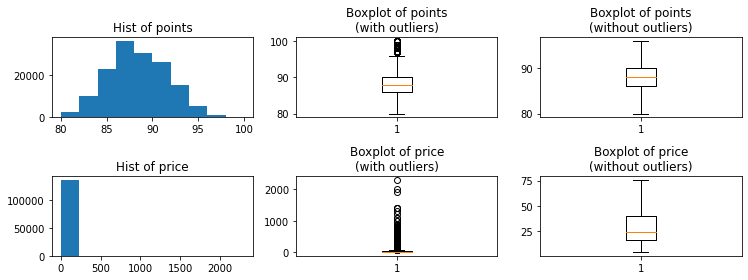

In [9]:
processing(csv_file_path, attributeType, MissingProcessing.eliminate)

- 用最高频率值来填补缺失值

country {'US': 62397, 'Italy': 23478, 'France': 21098, 'Spain': 8268, 'Chile': 5816, 'Argentina': 5631, 'Portugal': 5322, 'Australia': 4957, 'New Zealand': 3320, 'Austria': 3057}
designation {nan: 45735, 'Reserve': 2752, 'Reserva': 1810, 'Estate': 1571, 'Barrel sample': 1326, 'Riserva': 754, 'Barrel Sample': 639, 'Brut': 624, 'Crianza': 503, 'Estate Grown': 449}
points (80.0, 86.0, 88.0, 90.0, 100.0, 0)
price (4.0, 16.0, 22.0, 38.0, 2300.0, 13695)
province {'California': 44508, 'Washington': 9750, 'Tuscany': 7281, 'Bordeaux': 6111, 'Northern Spain': 4892, 'Mendoza Province': 4742, 'Oregon': 4589, 'Burgundy': 4308, 'Piedmont': 4093, 'Veneto': 3962}
region_1 {nan: 25060, 'Napa Valley': 6209, 'Columbia Valley (WA)': 4975, 'Mendoza': 3586, 'Russian River Valley': 3571, 'California': 3462, 'Paso Robles': 3053, 'Willamette Valley': 2096, 'Rioja': 1893, 'Toscana': 1885}
region_2 {nan: 89977, 'Central Coast': 13057, 'Sonoma': 11258, 'Columbia Valley': 9157, 'Napa': 8801, 'California Other': 35

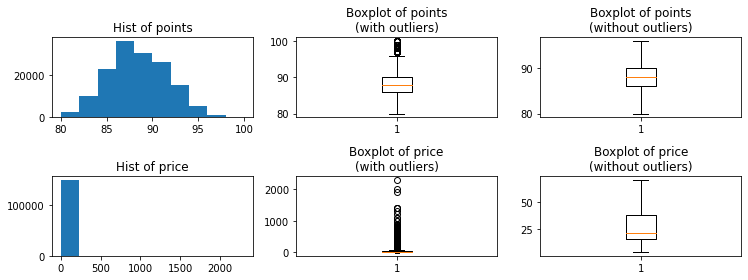

In [10]:
processing(csv_file_path, attributeType, MissingProcessing.frequencyFill)

- 通过属性的相关关系来填补缺失值

country {'US': 62397, 'Italy': 23478, 'France': 21098, 'Spain': 8268, 'Chile': 5816, 'Argentina': 5631, 'Portugal': 5322, 'Australia': 4957, 'New Zealand': 3320, 'Austria': 3057}
designation {nan: 45735, 'Reserve': 2752, 'Reserva': 1810, 'Estate': 1571, 'Barrel sample': 1326, 'Riserva': 754, 'Barrel Sample': 639, 'Brut': 624, 'Crianza': 503, 'Estate Grown': 449}
points (80.0, 86.0, 88.0, 90.0, 100.0, 0)
price (4.0, 16.0, 26.0, 38.0, 2300.0, 13695)
province {'California': 44508, 'Washington': 9750, 'Tuscany': 7281, 'Bordeaux': 6111, 'Northern Spain': 4892, 'Mendoza Province': 4742, 'Oregon': 4589, 'Burgundy': 4308, 'Piedmont': 4093, 'Veneto': 3962}
region_1 {nan: 25060, 'Napa Valley': 6209, 'Columbia Valley (WA)': 4975, 'Mendoza': 3586, 'Russian River Valley': 3571, 'California': 3462, 'Paso Robles': 3053, 'Willamette Valley': 2096, 'Rioja': 1893, 'Toscana': 1885}
region_2 {nan: 89977, 'Central Coast': 13057, 'Sonoma': 11258, 'Columbia Valley': 9157, 'Napa': 8801, 'California Other': 35

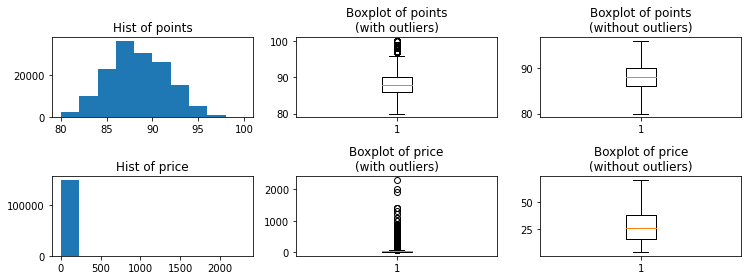

In [11]:
processing(csv_file_path, attributeType, MissingProcessing.relevanceFill)

- 通过数据对象之间的相似性来填补缺失值

country {'US': 62397, 'Italy': 23478, 'France': 21098, 'Spain': 8268, 'Chile': 5816, 'Argentina': 5631, 'Portugal': 5322, 'Australia': 4957, 'New Zealand': 3320, 'Austria': 3057}
designation {nan: 45735, 'Reserve': 2752, 'Reserva': 1810, 'Estate': 1571, 'Barrel sample': 1326, 'Riserva': 754, 'Barrel Sample': 639, 'Brut': 624, 'Crianza': 503, 'Estate Grown': 449}
points (80.0, 86.0, 88.0, 90.0, 100.0, 0)
price (4.0, 16.0, 26.0, 38.0, 2300.0, 13695)
province {'California': 44508, 'Washington': 9750, 'Tuscany': 7281, 'Bordeaux': 6111, 'Northern Spain': 4892, 'Mendoza Province': 4742, 'Oregon': 4589, 'Burgundy': 4308, 'Piedmont': 4093, 'Veneto': 3962}
region_1 {nan: 25060, 'Napa Valley': 6209, 'Columbia Valley (WA)': 4975, 'Mendoza': 3586, 'Russian River Valley': 3571, 'California': 3462, 'Paso Robles': 3053, 'Willamette Valley': 2096, 'Rioja': 1893, 'Toscana': 1885}
region_2 {nan: 89977, 'Central Coast': 13057, 'Sonoma': 11258, 'Columbia Valley': 9157, 'Napa': 8801, 'California Other': 35

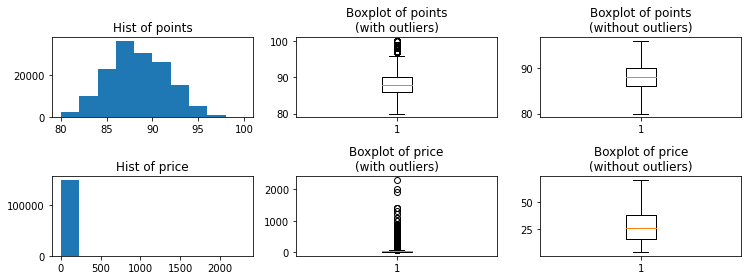

In [12]:
processing(csv_file_path, attributeType, MissingProcessing.similarityFill)

## 2. 分析Wine Reviews数据集的winemag-data-130k-v2.csv'文件

### csv文件路径

In [13]:
csv_file_path = 'D:/Data/data_mining/1/Wine Reviews/winemag-data-130k-v2.csv'

### 标注出无关属性、数值属性的列序号，其余的为标称属性

In [14]:
nonsense_columns = [0, 2, 11]
Numeric_columns = [4, 5]
attributeType = [AttributeType.Nonsense if i in nonsense_columns
                 else AttributeType.Numeric if i in Numeric_columns
                 else AttributeType.Nominal
                 for i in range(14)]

### 依次采用不同的缺失数据处理方法进行处理

- 将缺失部分剔除

country {'US': 54504, 'France': 22093, 'Italy': 19540, 'Spain': 6645, 'Portugal': 5691, 'Chile': 4472, 'Argentina': 3800, 'Austria': 3345, 'Australia': 2329, 'Germany': 2165}
designation {nan: 37465, 'Reserve': 2009, 'Estate': 1322, 'Reserva': 1259, 'Riserva': 698, 'Estate Grown': 621, 'Brut': 513, 'Dry': 413, 'Barrel sample': 375, 'Crianza': 343}
points (80.0, 86.0, 88.0, 91.0, 100.0, 0)
price (4.0, 17.0, 25.0, 42.0, 3300.0, 8996)
province {'California': 36247, 'Washington': 8639, 'Bordeaux': 5941, 'Tuscany': 5897, 'Oregon': 5373, 'Burgundy': 3980, 'Northern Spain': 3851, 'Piedmont': 3729, 'Mendoza Province': 3264, 'Veneto': 2716}
region_1 {nan: 21247, 'Napa Valley': 4480, 'Columbia Valley (WA)': 4124, 'Russian River Valley': 3091, 'California': 2629, 'Paso Robles': 2350, 'Willamette Valley': 2301, 'Mendoza': 2301, 'Alsace': 2163, 'Champagne': 1613}
region_2 {nan: 79460, 'Central Coast': 11065, 'Sonoma': 9028, 'Columbia Valley': 8103, 'Napa': 6814, 'Willamette Valley': 3423, 'Californ

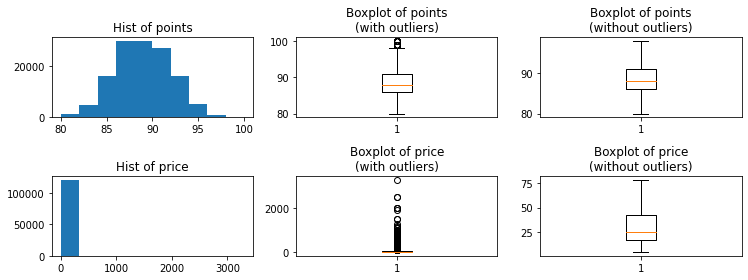

In [15]:
processing(csv_file_path, attributeType, MissingProcessing.eliminate)

- 用最高频率值来填补缺失值

country {'US': 54504, 'France': 22093, 'Italy': 19540, 'Spain': 6645, 'Portugal': 5691, 'Chile': 4472, 'Argentina': 3800, 'Austria': 3345, 'Australia': 2329, 'Germany': 2165}
designation {nan: 37465, 'Reserve': 2009, 'Estate': 1322, 'Reserva': 1259, 'Riserva': 698, 'Estate Grown': 621, 'Brut': 513, 'Dry': 413, 'Barrel sample': 375, 'Crianza': 343}
points (80.0, 86.0, 88.0, 91.0, 100.0, 0)
price (4.0, 18.0, 25.0, 40.0, 3300.0, 8996)
province {'California': 36247, 'Washington': 8639, 'Bordeaux': 5941, 'Tuscany': 5897, 'Oregon': 5373, 'Burgundy': 3980, 'Northern Spain': 3851, 'Piedmont': 3729, 'Mendoza Province': 3264, 'Veneto': 2716}
region_1 {nan: 21247, 'Napa Valley': 4480, 'Columbia Valley (WA)': 4124, 'Russian River Valley': 3091, 'California': 2629, 'Paso Robles': 2350, 'Willamette Valley': 2301, 'Mendoza': 2301, 'Alsace': 2163, 'Champagne': 1613}
region_2 {nan: 79460, 'Central Coast': 11065, 'Sonoma': 9028, 'Columbia Valley': 8103, 'Napa': 6814, 'Willamette Valley': 3423, 'Californ

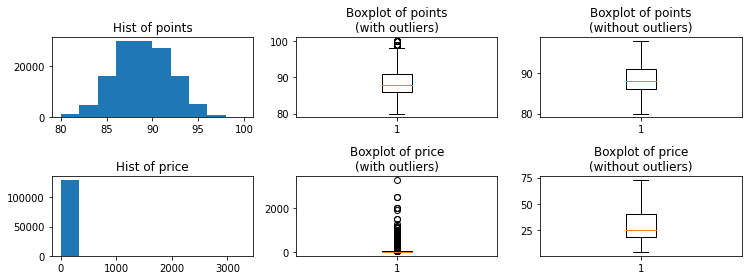

In [16]:
processing(csv_file_path, attributeType, MissingProcessing.frequencyFill)

- 通过属性的相关关系来填补缺失值

country {'US': 54504, 'France': 22093, 'Italy': 19540, 'Spain': 6645, 'Portugal': 5691, 'Chile': 4472, 'Argentina': 3800, 'Austria': 3345, 'Australia': 2329, 'Germany': 2165}
designation {nan: 37465, 'Reserve': 2009, 'Estate': 1322, 'Reserva': 1259, 'Riserva': 698, 'Estate Grown': 621, 'Brut': 513, 'Dry': 413, 'Barrel sample': 375, 'Crianza': 343}
points (80.0, 86.0, 88.0, 91.0, 100.0, 0)
price (4.0, 18.0, 28.0, 40.0, 3300.0, 8996)
province {'California': 36247, 'Washington': 8639, 'Bordeaux': 5941, 'Tuscany': 5897, 'Oregon': 5373, 'Burgundy': 3980, 'Northern Spain': 3851, 'Piedmont': 3729, 'Mendoza Province': 3264, 'Veneto': 2716}
region_1 {nan: 21247, 'Napa Valley': 4480, 'Columbia Valley (WA)': 4124, 'Russian River Valley': 3091, 'California': 2629, 'Paso Robles': 2350, 'Willamette Valley': 2301, 'Mendoza': 2301, 'Alsace': 2163, 'Champagne': 1613}
region_2 {nan: 79460, 'Central Coast': 11065, 'Sonoma': 9028, 'Columbia Valley': 8103, 'Napa': 6814, 'Willamette Valley': 3423, 'Californ

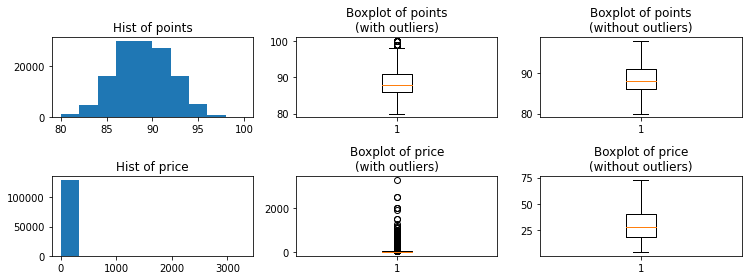

In [17]:
processing(csv_file_path, attributeType, MissingProcessing.relevanceFill)

- 通过数据对象之间的相似性来填补缺失值

country {'US': 54504, 'France': 22093, 'Italy': 19540, 'Spain': 6645, 'Portugal': 5691, 'Chile': 4472, 'Argentina': 3800, 'Austria': 3345, 'Australia': 2329, 'Germany': 2165}
designation {nan: 37465, 'Reserve': 2009, 'Estate': 1322, 'Reserva': 1259, 'Riserva': 698, 'Estate Grown': 621, 'Brut': 513, 'Dry': 413, 'Barrel sample': 375, 'Crianza': 343}
points (80.0, 86.0, 88.0, 91.0, 100.0, 0)
price (4.0, 18.0, 28.0, 40.0, 3300.0, 8996)
province {'California': 36247, 'Washington': 8639, 'Bordeaux': 5941, 'Tuscany': 5897, 'Oregon': 5373, 'Burgundy': 3980, 'Northern Spain': 3851, 'Piedmont': 3729, 'Mendoza Province': 3264, 'Veneto': 2716}
region_1 {nan: 21247, 'Napa Valley': 4480, 'Columbia Valley (WA)': 4124, 'Russian River Valley': 3091, 'California': 2629, 'Paso Robles': 2350, 'Willamette Valley': 2301, 'Mendoza': 2301, 'Alsace': 2163, 'Champagne': 1613}
region_2 {nan: 79460, 'Central Coast': 11065, 'Sonoma': 9028, 'Columbia Valley': 8103, 'Napa': 6814, 'Willamette Valley': 3423, 'Californ

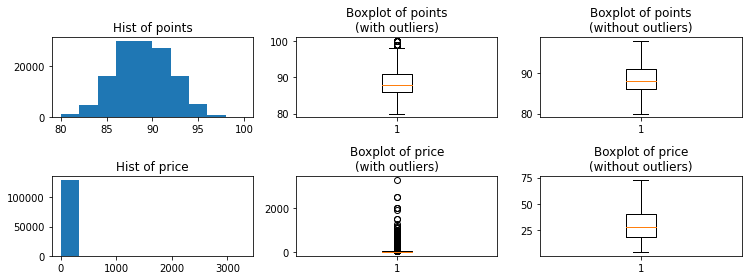

In [18]:
processing(csv_file_path, attributeType, MissingProcessing.similarityFill)

## 3. 分析Chicago Building Violations数据集的building-violations.csv'文件

### csv文件路径

In [19]:
csv_file_path = 'D:/Data/data_mining/1/Chicago Building Violations/building-violations.csv'

### 标注出无关属性、数值属性的列序号，其余的为标称属性

In [20]:
nonsense_columns = [0, 1, 2, 5, 8, 25]
Numeric_columns = [22, 23, 24, 26, 29, 30, 31]
attributeType = [AttributeType.Nonsense if i in nonsense_columns
                 else AttributeType.Numeric if i in Numeric_columns
                 else AttributeType.Nominal
                 for i in range(32)]

### 依次采用不同的缺失数据处理方法进行处理

- 将缺失部分剔除

VIOLATION CODE {'CN190019': 89995, 'CN196029': 58136, 'CN061014': 51946, 'EV1110': 43700, 'CN070024': 43673, 'CN193110': 37127, 'CN104015': 34641, 'CN070014': 32093, 'CN197019': 30793, 'NC2011': 28750}
VIOLATION STATUS {'OPEN': 1030958, 'COMPLIED': 641247, 'NO ENTRY': 5583}
VIOLATION DESCRIPTION {'ARRANGE PREMISE INSPECTION': 90004, 'POST OWNER/MANAGERS NAME/#': 58136, 'REPAIR EXTERIOR WALL': 51946, 'MAINTAIN OR REPAIR ELECT ELEVA': 43700, 'REPAIR PORCH SYSTEM': 43673, 'VACANT BUILDING - REGISTER': 37127, 'REPLCE WINDOW PANES, PLEXGLAS': 34641, 'REPAIR EXTERIOR STAIR': 32093, 'INSTALL SMOKE DETECTORS': 30846, 'PLANS & PERMITS REQ - CONTRCTR': 28750}
VIOLATION LOCATION {nan: 897282, 'OTHER   :    :': 284277, 'OTHER   :    :OTHER': 35182, 'OTHER   :    :BUILDING': 21934, 'EXTERIOR:E   :': 21522, 'EXTERIOR:W   :': 19460, 'EXTERIOR:S   :': 17053, 'OTHER   :    :BL00006': 16951, 'EXTERIOR:N   :': 16004, 'INTERIOR:001 :': 13016}
VIOLATION ORDINANCE {'Arrange for inspection of premises. (13-1

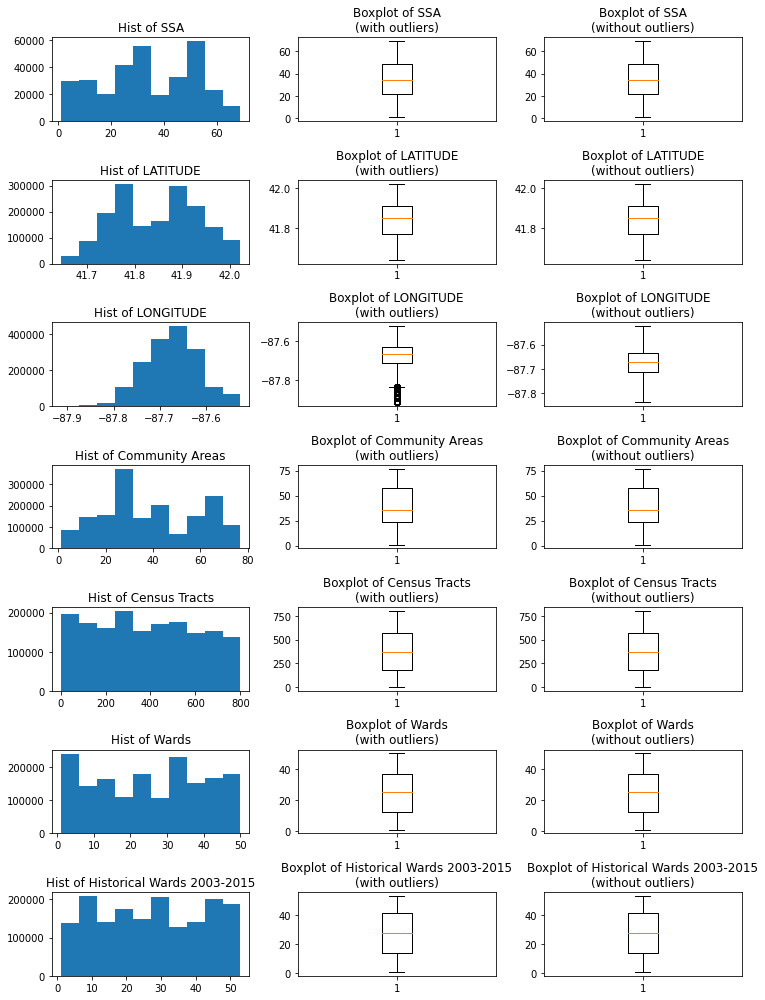

In [21]:
processing(csv_file_path, attributeType, MissingProcessing.eliminate)

- 用最高频率值来填补缺失值

VIOLATION CODE {'CN190019': 89995, 'CN196029': 58136, 'CN061014': 51946, 'EV1110': 43700, 'CN070024': 43673, 'CN193110': 37127, 'CN104015': 34641, 'CN070014': 32093, 'CN197019': 30793, 'NC2011': 28750}
VIOLATION STATUS {'OPEN': 1030958, 'COMPLIED': 641247, 'NO ENTRY': 5583}
VIOLATION DESCRIPTION {'ARRANGE PREMISE INSPECTION': 90004, 'POST OWNER/MANAGERS NAME/#': 58136, 'REPAIR EXTERIOR WALL': 51946, 'MAINTAIN OR REPAIR ELECT ELEVA': 43700, 'REPAIR PORCH SYSTEM': 43673, 'VACANT BUILDING - REGISTER': 37127, 'REPLCE WINDOW PANES, PLEXGLAS': 34641, 'REPAIR EXTERIOR STAIR': 32093, 'INSTALL SMOKE DETECTORS': 30846, 'PLANS & PERMITS REQ - CONTRCTR': 28750}
VIOLATION LOCATION {nan: 897282, 'OTHER   :    :': 284277, 'OTHER   :    :OTHER': 35182, 'OTHER   :    :BUILDING': 21934, 'EXTERIOR:E   :': 21522, 'EXTERIOR:W   :': 19460, 'EXTERIOR:S   :': 17053, 'OTHER   :    :BL00006': 16951, 'EXTERIOR:N   :': 16004, 'INTERIOR:001 :': 13016}
VIOLATION ORDINANCE {'Arrange for inspection of premises. (13-1

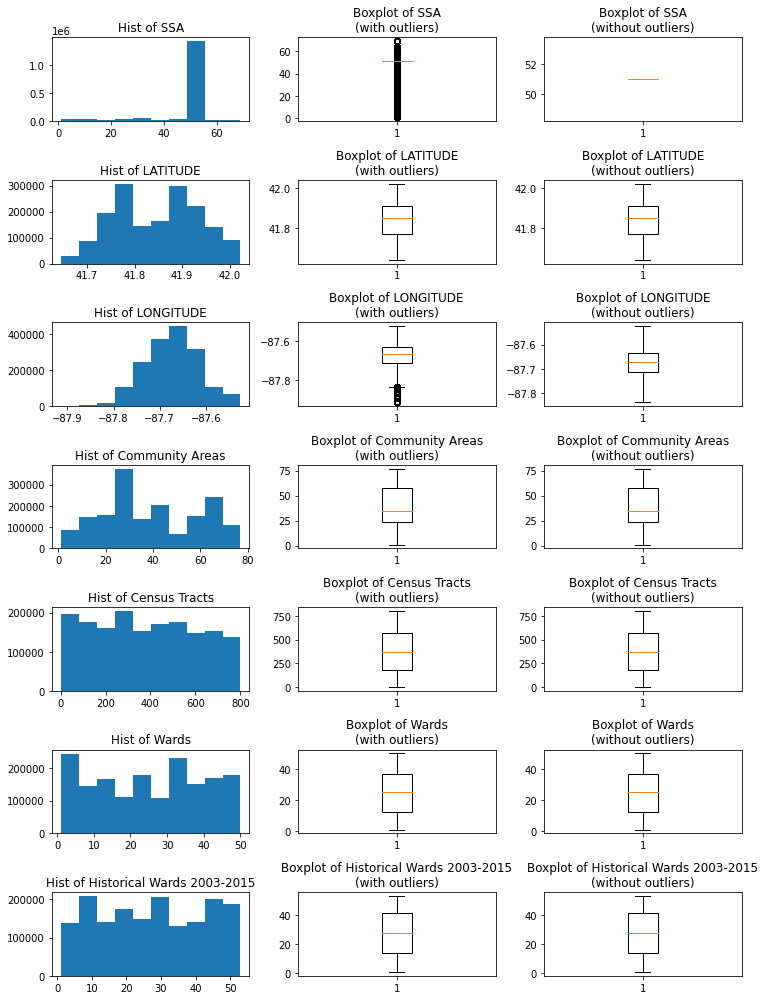

In [22]:
processing(csv_file_path, attributeType, MissingProcessing.frequencyFill)

- 通过属性的相关关系来填补缺失值

VIOLATION CODE {'CN190019': 89995, 'CN196029': 58136, 'CN061014': 51946, 'EV1110': 43700, 'CN070024': 43673, 'CN193110': 37127, 'CN104015': 34641, 'CN070014': 32093, 'CN197019': 30793, 'NC2011': 28750}
VIOLATION STATUS {'OPEN': 1030958, 'COMPLIED': 641247, 'NO ENTRY': 5583}
VIOLATION DESCRIPTION {'ARRANGE PREMISE INSPECTION': 90004, 'POST OWNER/MANAGERS NAME/#': 58136, 'REPAIR EXTERIOR WALL': 51946, 'MAINTAIN OR REPAIR ELECT ELEVA': 43700, 'REPAIR PORCH SYSTEM': 43673, 'VACANT BUILDING - REGISTER': 37127, 'REPLCE WINDOW PANES, PLEXGLAS': 34641, 'REPAIR EXTERIOR STAIR': 32093, 'INSTALL SMOKE DETECTORS': 30846, 'PLANS & PERMITS REQ - CONTRCTR': 28750}
VIOLATION LOCATION {nan: 897282, 'OTHER   :    :': 284277, 'OTHER   :    :OTHER': 35182, 'OTHER   :    :BUILDING': 21934, 'EXTERIOR:E   :': 21522, 'EXTERIOR:W   :': 19460, 'EXTERIOR:S   :': 17053, 'OTHER   :    :BL00006': 16951, 'EXTERIOR:N   :': 16004, 'INTERIOR:001 :': 13016}
VIOLATION ORDINANCE {'Arrange for inspection of premises. (13-1

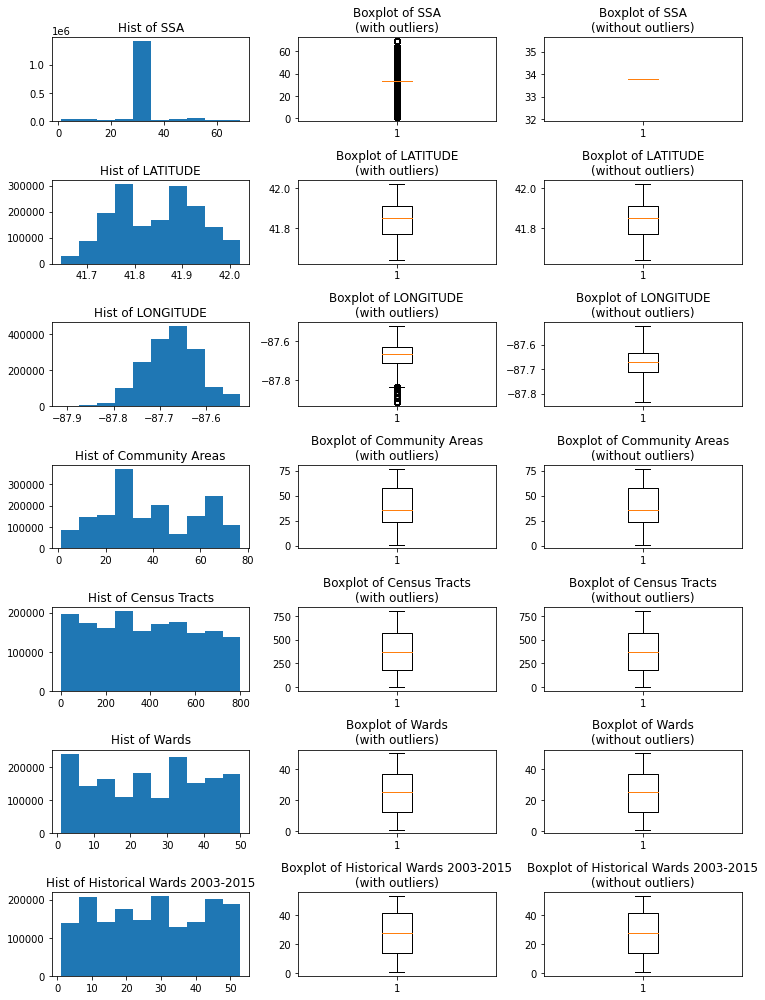

In [23]:
processing(csv_file_path, attributeType, MissingProcessing.relevanceFill)

- 通过数据对象之间的相似性来填补缺失值

VIOLATION CODE {'CN190019': 89995, 'CN196029': 58136, 'CN061014': 51946, 'EV1110': 43700, 'CN070024': 43673, 'CN193110': 37127, 'CN104015': 34641, 'CN070014': 32093, 'CN197019': 30793, 'NC2011': 28750}
VIOLATION STATUS {'OPEN': 1030958, 'COMPLIED': 641247, 'NO ENTRY': 5583}
VIOLATION DESCRIPTION {'ARRANGE PREMISE INSPECTION': 90004, 'POST OWNER/MANAGERS NAME/#': 58136, 'REPAIR EXTERIOR WALL': 51946, 'MAINTAIN OR REPAIR ELECT ELEVA': 43700, 'REPAIR PORCH SYSTEM': 43673, 'VACANT BUILDING - REGISTER': 37127, 'REPLCE WINDOW PANES, PLEXGLAS': 34641, 'REPAIR EXTERIOR STAIR': 32093, 'INSTALL SMOKE DETECTORS': 30846, 'PLANS & PERMITS REQ - CONTRCTR': 28750}
VIOLATION LOCATION {nan: 897282, 'OTHER   :    :': 284277, 'OTHER   :    :OTHER': 35182, 'OTHER   :    :BUILDING': 21934, 'EXTERIOR:E   :': 21522, 'EXTERIOR:W   :': 19460, 'EXTERIOR:S   :': 17053, 'OTHER   :    :BL00006': 16951, 'EXTERIOR:N   :': 16004, 'INTERIOR:001 :': 13016}
VIOLATION ORDINANCE {'Arrange for inspection of premises. (13-1

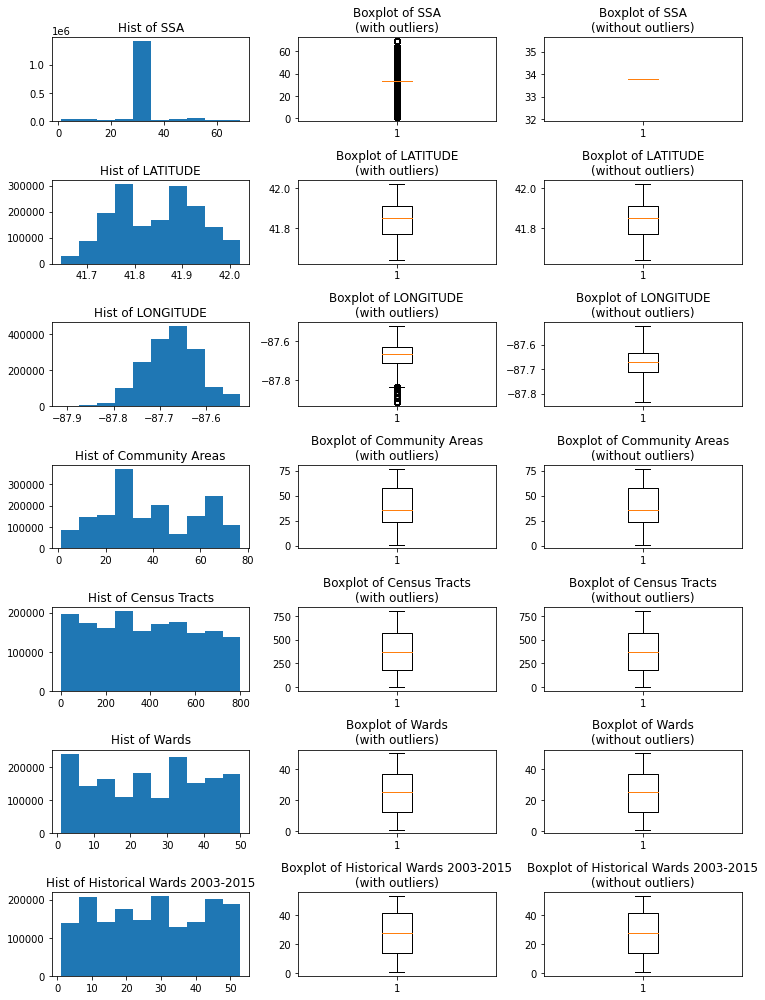

In [23]:
processing(csv_file_path, attributeType, MissingProcessing.similarityFill)